In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#create random initial spins in an NxN array
#Need to take into account the position of the spins

#Pick one random spin and flip it
#Calculate energy difference between the old and the new state
#If E_new > E_old: keep new state
#If E_new < E_old: calculate q = p(x')/p(x).
#Draw random number: if random number lower than q: accept new state

In [66]:
def initial_spins(N):
    spin_0 = np.random.choice([1,-1])
    lattice = np.random.choice([spin_0, -spin_0], size=(N,N), p=[0.8, 0.2])
    
    return lattice



# def system_energy(lattice, coupling_constant):
#     L = len(lattice[0,:])
#     ham = 0
#     for i in range(L):
#         for j in range(L):
#             h = 0
#             h = lattice[i,j]*lattice[(i-1)%L,j-1] + lattice[i,j]*lattice[(i-1)%L,(j+1)%L] + lattice[i,j]*lattice[(i+1)%L,(j+1)%L] + lattice[i,j]*lattice[(i+1)%L,(j-1)%L]
#             ham += h
#     total_energy = -coupling_constant*ham
#     return total_energy


def system_energy(lattice, J):
#     this method is way faster the the double for loop

    energy = -J * np.sum(lattice * (np.roll(lattice, -1, axis=0) + np.roll(lattice, -1, axis=1)))
    return energy




def energy_difference(old_lattice, new_lattice):
    delta_energy = total_hamiltonian(new_lattice) - total_hamiltonian(old_lattice)
    return delta_energy


def monte_carlo(lattice, coupling_constant, temperature):
    beta = 1/temperature
    size = len(lattice[0,:])
    random_x, random_y = np.random.randint(size, size=2)
    delta_E = 2 * coupling_constant * lattice[random_x, random_y] * (lattice[(random_x-1)%size, random_y] 
                                                              + lattice[(random_x+1)%size, random_y] 
                                                              + lattice[random_x, (random_y-1)%size] 
                                                              + lattice[random_x, (random_y+1)%size])
    if delta_E <= 0:
        lattice[random_x, random_y] *= -1
        return lattice, delta_E
    if np.random.rand() < np.exp(-delta_E * beta):
        lattice[random_x, random_y] *= -1
        return lattice, delta_E
    else:
        return lattice, 0

def show_snapshot(lattice, timestep):
    
    plt.imshow(lattice, cmap='binary')
    plt.title(f'Timestep {timestep}')
    plt.show()


def ising_simulation(size, coupling_constant, temperature, timesteps):
#     two metropolis algorithm starting from the same initial lattice
    lattice = initial_spins(size)
    lattice2 = np.copy(lattice)
    energies = []
    energies2 = []
    magnetizations = []
    magnetizations2 = []
    t_to_eq = 50000
    for i in range(timesteps + t_to_eq):
        lattice, delta_E = monte_carlo(lattice, coupling_constant, temperature) 
        lattice2, delta_E2 = monte_carlo(lattice2, coupling_constant, temperature)
        if i >= t_to_eq:
            energies.append(system_energy(lattice, coupling_constant)/size**2)
            magnetizations.append(np.sum(lattice)/size**2)
            energies2.append(system_energy(lattice2, coupling_constant)/size**2)
            magnetizations2.append(np.sum(lattice2)/size**2)
#             if i%1000 == 0:
#                 show_snapshot(lattice, i-t_to_eq)
    return np.array(energies), np.array(magnetizations), np.array(energies2), np.array(magnetizations2)

def auto_correlation(magnetization, timestep):
    corr_function = np.zeros(timestep)
    for t in range(timestep):
        corr_function[t] = (np.sum(magnetization[0:timestep-t]*magnetization[t:timestep])) * (timestep-t)**(-1) - (np.sum(magnetization[0:timestep-t])*np.sum(magnetization[t:timestep])) * (timestep-t)**(-2) 
        
    return corr_function

def corr_time(chi):
    i = 0
    integral = 0
    while chi[i] >= 0:
        integral += chi[i]/chi[0]
        i += 1
    return integral

def magnetic_susceptibility(magnetization, tau, temperature, n_spins, t_max):
    """Computes the magnetic susceptibility per spin for equal blocks of size 16*tau"""
    #block_length = 16*tau
    block_length = int(16*tau)
    beta = 1/temperature
    magn_susc = []    
    for j in np.arange(0, np.int(t_max/block_length)):
        magn_susc.append((beta/n_spins**2)*(np.mean(magnetization[j*block_length:(j+1)*block_length]**2)-np.mean(magnetization[j*block_length:(j+1)*block_length])**2))
    return np.array(magn_susc)

def specific_heat(energy, tau, temperature, n_spins, t_max):
    """Computes the specific heat per spin for equal blocks of size 16*tau"""
    block_length = 16*tau
    k_B = 1
    spec_heat = []
    for h in np.arange(0, np.int(t_max/block_length)):
        spec_heat.append((1/(k_B*temperature**2*n_spins**2))*(np.mean(energy[h*block_length:(h+1)*block_length]**2)-np.mean(energy[h*block_length:(h+1)*block_length])**2))
    return np.array(spec_heat)

def avg_magnetization_and_stdev(magnetization, tau, t_max):
    #t_max = sweeps
    mean_magnetization = np.mean(np.abs(magnetization)) 
    stdev_magnetization = np.sqrt((2*tau/t_max)*(np.mean(magnetization**2)-np.mean(magnetization)**2))
    return mean_magnetization, stdev_magnetization
                                  
def avg_energy_and_stdev(energy, tau, t_max):
    mean_energy = np.mean(energy)
    stdev_energy = np.sqrt((2*tau/t_max)*(np.mean(energy**2)-np.mean(energy)**2))
    return mean_energy, stdev_energy
                           
def avg_magn_susceptibility_and_stdev(magn_susceptibility, tau, t_max):
    mean_susceptibility = np.mean(magn_susceptibility)
    stdev_susceptibility = np.sqrt((2*tau/t_max)*(np.mean(magn_susceptibility**2)-np.mean(magn_susceptibility)**2))
    return mean_susceptibility, stdev_susceptibility

def avg_specific_heat_and_stdev(specific_heat, tau, t_max):
    mean_specific_heat = np.mean(specific_heat)
    stdev_specific_heat = np.sqrt((2*tau/t_max)*(np.mean(specific_heat**2)-np.mean(specific_heat)**2))
    return mean_specific_heat, stdev_specific_heat

In [134]:
#Define constants
n_spins = 50
coupling_constant = 1
temperature = 4.
#n_steps = 70000
n_steps = 500000
sweeps = int(n_steps/n_spins**2)

In [107]:
# Run the simulation
energies, magnetizations, energies2, magnetizations2 = ising_simulation(n_spins, coupling_constant, temperature, n_steps)

In [87]:
#Sometimes quantity per spin needed, sometimes total
total_energies = energies*n_spins**2
total_energies2 = energies2*n_spins**2
total_magnetizations = magnetizations*n_spins**2
total_magnetizations2 = magnetizations2*n_spins**2

In [145]:
#chi = auto_correlation(magnetizations, n_steps)
chi = auto_correlation(magnetizations, sweeps)

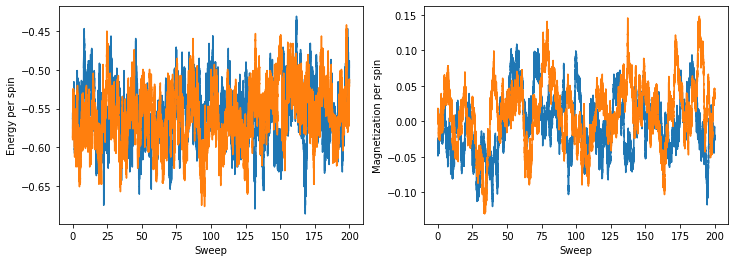

In [137]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.arange(0,len(energies))/n_spins**2, energies)
ax1.plot(np.arange(0,len(energies2))/n_spins**2, energies2)
ax1.set_xlabel("Sweep")
ax1.set_ylabel("Energy per spin")
ax2.plot(np.arange(0,len(magnetizations))/n_spins**2, magnetizations)
ax2.plot(np.arange(0,len(magnetizations2))/n_spins**2, magnetizations2)
ax2.set_xlabel("Sweep")
ax2.set_ylabel("Magnetization per spin")
plt.show()

Text(0.5, 1.0, 'Auto-correlation $\\chi(t)/\\chi(0)$')

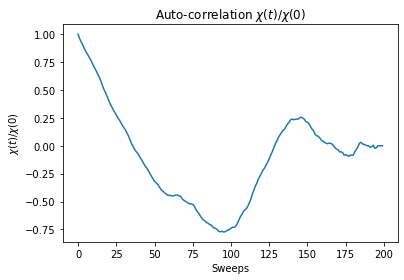

In [139]:
plt.plot(np.arange(0,len(chi)), chi/chi[0])
plt.xlabel('Sweeps')
plt.ylabel(r'$\chi(t)/\chi(0)$')
plt.title(r'Auto-correlation $\chi(t)/\chi(0)$')

In [140]:
for i in range(len(chi)):
    if chi[i]<0:
        print(chi[i], i)
        break

-4.920880428268756e-08 36


In [141]:
tau = corr_time(chi)

print(tau)

18.02440666918891


In [142]:
mean_magn, stdev_magn = avg_magnetization_and_stdev(magnetizations, tau, sweeps)
print(mean_magn, stdev_magn)
mean_energy, stdev_energy = avg_energy_and_stdev(energies, tau, sweeps)
print(mean_energy, stdev_energy)

0.033194793599999994 0.01740752051231413
-0.5565594208000001 0.015372007482608124


In [143]:
magn_sus = magnetic_susceptibility(magnetizations, tau, temperature, n_spins, sweeps)
print(magn_sus)

[]
